# DeepGuard: Deepfake Face Image Detection

This notebook trains an EfficientNet-B0 based binary classifier to distinguish **real** human face photographs from **AI-generated / deepfake** faces.

**Dataset:** 3,212 face images (1,606 real + 1,606 fake) from the DF40 benchmark, which covers 40 distinct deepfake generation techniques including DeepFaceLab, HeyGen, Midjourney, etc.

**Approach:**
- Transfer learning from ImageNet-pretrained EfficientNet-B0
- Two-phase training: frozen backbone warm-up, then full fine-tuning
- Early stopping on validation AUC to prevent overfitting

---
**Runtime:** Supports CUDA (NVIDIA), MPS (Apple Silicon), or CPU. Apple Silicon Macs use Metal Performance Shaders for GPU acceleration.

## 1. Setup

In [1]:
!pip install -q timm scikit-learn seaborn

pyenv: pip: command not found



The `pip' command exists in these Python versions:
  3.11.9

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [2]:
import os, random, glob, math, time, warnings
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, accuracy_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font_scale=1.15)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f'Using device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
elif device == 'mps':
    print('GPU: Apple Silicon (Metal Performance Shaders)')

/Users/alphaskynet/Downloads/Project Deepfake Image detector/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
GPU: Apple Silicon (Metal Performance Shaders)


## 2. Dataset Download & Preparation

We use the validation split of the DF40-based deepfake face classification dataset hosted on HuggingFace. It contains 1,606 real and 1,606 fake face images sourced from 40 different deepfake generation methods.

In [3]:
!mkdir -p data
if not os.path.exists('data/val'):
    print('Downloading dataset (~588 MB)...')
    !curl -L -o /tmp/deepfake_val.zip \
        "https://huggingface.co/datasets/pujanpaudel/deepfake_face_classification/resolve/main/val.zip" \
        --progress-bar
    !unzip -q /tmp/deepfake_val.zip -d data/
    !rm /tmp/deepfake_val.zip
    print('Done!')
else:
    print('Dataset already present, skipping download.')


######################################################################### 100.0%


                                                                            0.1%


                                                                            0.4%


                                                                            0.6%


                                                                            0.8%


                                                                            1.0%


                                                                            1.1%


                                                                            1.3%


#                                                                           1.4%


#                                                                           1.6%


#                                                                           1.7%


#                                                                           1.8%


#                                                                           2.0%


#                                             

                              2.2%


#                                                                           2.5%


#                                                                           2.7%


##                                                                          3.0%


##                                                                          3.3%


##                                                                          3.6%


##                                                                          3.9%


###                                                                         4.3%


###                                                                         4.6%


###                                                                         4.8%


###                                                                         4.9%


###                                                                         5.1%


###                                                                         5.2%


###                                                                         5.4%


####                                                                        5.6%


####                                                                        5.8%


####                                                                        6.0%


####                                                                        6.1%


####                                                                        6.5%


####                                                                        6.8%


#####                                                                       7.1%


#####                                     

                                  7.4%


#####                                                                       7.7%


#####                                                                       8.0%


#####                                                                       8.1%


######                                                                      8.3%


######                                                                      8.5%


######                                                                      8.8%


######                                                                      9.0%


######                                       

                               9.2%


######                                                                      9.4%


######                                                                      9.6%


#######                                                                     9.8%


#######                                                                    10.0%


#######                                                                    10.2%


#######                                                                    10.4%


#######                                                                    10.5%


#######                                                                    10.8%


########                                                                   11.0%


########                                                                   11.3%


########                                                                   11.6%


########                                                                   11.8%


########                                                                   12.1%


#########                                                                  12.4%


#########                                                                  12.7%


#########                                                                  12.9%


#########                                                                  13.1%


#########                    

                                              13.3%


#########                                                                  13.5%


#########                                                                  13.7%


##########                                

                                 13.9%


##########                                                                 14.0%


##########                                                                 14.2%


##########                                                                 14.4%


##########                                                                 14.6%


##########                                                                 14.8%


##########                                                                 15.0%


###########                                                                15.3%


###########                                                                15.5%


###########                                                                15.8%


###########                                                 

               16.1%


###########                                                                16.4%


############                                                               16.7%


############                                                               16.9%


############                                                               17.3%


############                                                               17.6%


#############                                                              17.9%


#############                                                              18.1%


#############                                                              18.5%


#############                                                              18.8%


#############                                                              19.1%


##############                                                             19.5%


##############                                                             19.8%


##############                                                             20.2%


###############                                                            20.6%


###############                                                            21.0%


###############                                                            21.3%


###############                           

                                 21.7%


################                                                           22.0%


################                                                           22.3%


################                                                           22.5%


################                                                           22.7%


################                                                           22.9%


################                                                           23.2%


#################                                                          23.4%


#################                  

                                        23.5%


#################                                                          23.7%


#################                                                          23.9%


#################                                                          24.1%


#################                                                          24.3%


#################                                                          24.5%


##################                                                         24.8%


##################                                                         25.1%


##################                                                         25.3%


##################                                                         25.6%


##################                                                         25.9%


###################                                                        26.2%


###################                                                        26.4%


###################                                                        26.5%


###################                                                        26.7%


###################                                                        26.9%


###################                                                        27.1%


###################                                                        27.2%


###################                                                        27.4%


####################                                                      

 27.6%


####################                                                       27.7%


####################                                                       27.9%


####################                                                       28.1%


####################                                                       28.4%


####################                                                       28.6%


#####################                                                      28.8%


#####################                                                      29.0%


#####################                                                      29.3%


#####################                                                      29.6%


#####################                            

                          29.9%


######################                                                     30.2%


######################                                                     30.4%


######################                                                     30.6%


######################                                                     30.8%


######################                                                     31.0%


######################                                                     31.3%


#######################                                                    31.5%


#######################                                   

                 31.8%


#######################                                                    32.1%


#######################                                                    32.4%


#######################                                                    32.7%


#######################                                                    32.9%


########################                                                   33.1%


########################                                                   33.3%


########################                                                   33.5%


########################                                                   33.7%


########################                                                   33.9%


########################                                                   34.1%


#########################                                                  34.4%


#########################                                                  34.6%


#########################                                                  34.8%


#########################                                                  35.0%


#########################                                                  35.3%


#########################                                                  35.5%


##########################                                                 35.8%


##########################                                                 36.1%


##########################                                                 36.4%


##########################                                                 36.8%


###########################                                                37.2%


###########################                                                37.4%


###########################                                                37.6%


###########################                                                37.8%


###########################                                                38.0%


###########################                                                38.2%


############################                                               38.4%


############################                                               38.6%


############################                                               38.8%


############################                                               39.1%


############################                                               39.3%


############################                                               39.5%


#############################                                              39.8%


#############################                                              40.0%


#############################                                              40.0%


#############################                                              40.0%


#############################                                              40.3%


#############################                                              40.6%


#############################                                              40.9%


##############################                                             41.2%


##############################                                             41.4%


##############################                                             41.6%


##############################                                             41.8%


##############################                                             42.0%


##############################                                             42.3%


###############################                                            42.5%


###############################                                            42.8%


###############################                                            43.0%


###############################                                            43.2%


###############################                                            43.4%


###############################                                            43.6%


###############################                                            43.8%


################################                                           44.0%


################################                                           44.2%


################################                                           44.4%


################################                                           44.6%


################################                        

                   44.9%


################################                                           45.1%


#################################                                          45.4%


#################################                                          45.6%


#################################                                          45.9%


#################################                                          46.2%


#################################                                          46.5%


##################################                                         46.9%


##################################              

                           47.1%


##################################                                         47.3%


##################################                                         47.5%


##################################                                         47.7%


##################################                                         47.9%


###################################                                        48.1%


###################################                                        48.3%


###################################                                        48.5%


###################################                                        48.7%


###################################                                        48.9%


###################################                                        49.2%


####################################                                       49.4%


####################################                                       49.7%


####################################                                       50.0%


####################################                   

                    50.3%


####################################                                       50.6%


#####################################                                      50.9%


#####################################                                      51.2%


#####################################                                      51.5%


#####################################                                      51.9%


######################################                                     52.1%


######################################                                     52.4%


######################################                                     52.6%


######################################                                     52.8%


######################################                                     53.0%


######################################                                     53.2%


######################################                                     53.4%


#######################################                                    53.6%


#######################################                                    53.8%


#######################################                                    54.0%


#######################################                                    54.2%


#######################################                                    54.4%


#######################################                                    54.6%


########################################                                   54.8%


########################################                                   55.0%


########################################                                   55.3%


########################################                                   55.5%


########################################                                   55.7%


########################################                                   56.0%


#########################################                                  56.3%


#########################################                                  56.6%


#########################################                                  56.9%


#########################################                                  57.2%


#########################################   

                               57.5%


##########################################                                 57.7%


##########################################                                 57.8%


##########################################                                 58.1%


##########################################                                 58.3%


##########################################                                 58.5%


##########################################                                 58.7%


###########################################                                58.9%


###########################################                                59.1%


###########################################                                59.4%


###########################################                                59.6%


###########################################                                59.8%


###########################################                                60.0%


###########################################                                60.1%


############################################                               60.4%


############################################                               60.6%


############################################                               60.8%


############################################                               61.1%


############################################                    

           61.3%


############################################                               61.6%


#############################################                              61.8%


#############################################                              62.2%


#############################################                              62.5%


#############################################                              62.8%


##############################################                             63.1%


##############################################                             63.3%


##############################################                             63.5%


##############################################                             63.7%


##############################################     

                        64.0%


##############################################                             64.1%


##############################################                             64.4%


###############################################                            64.6%


###############################################                            64.8%


###############################################                            65.0%


###############################################                            65.2%


###############################################                            65.4%


###############################################                            65.7%


################################################                           65.9%


################################################                           66.1%


################################################                           66.4%


################################################                           66.7%


################################################                           67.0%


#################################################                          67.3%


#################################################                          67.5%


#################################################                          67.8%


#################################################                          68.0%


#################################################                          68.3%


#################################################                          68.3%


#################################################                          68.4%


#################################################                          68.5%


##################################################      

                   68.8%


##################################################                         69.1%


##################################################       

                  69.4%


##################################################                         69.4%


##################################################                         69.7%


###################################################                        69.9%


###################################################                        70.1%


###################################################                        70.3%


###################################################                        70.5%


###################################################                        70.6%


###################################################                        70.8%


###################################################  

                      71.0%


###################################################                        71.1%


####################################################                       71.3%


####################################################                       71.5%


####################################################                       71.7%


####################################################                       72.0%


####################################################                       72.2%


####################################################                       72.4%


#####################################################                      72.7%


#####################################################                      72.9%


#####################################################                      73.2%


#####################################################                      73.4%


#####################################################                      73.7%


#####################################################                      73.9%


######################################################                     74.1%


######################################################                     74.3%


######################################################                     74.5%


######################################################                     74.8%


######################################################                     75.0%


######################################################                    

 75.2%


#######################################################                    75.4%


#######################################################                    75.6%


#######################################################                    75.9%


#######################################################                    76.1%


#######################################################                    76.4%


########################################################                   76.8%


########################################################                   77.0%


#############################################

###########                   77.3%


##########################################

##############                   77.5%


########################################################                   77.7%


########################################################                   77.9%


#########################################################                  78.1%


#########################################################                  78.3%


#########################################################                  78.5%


#########################################################                  78.6%


#########################################################                  78.9%


#######################################

##################                  79.1%


#########################################################             

     79.4%


##########################################################                 79.6%


##########################################################                 79.8%


##########################################################                 80.0%


##########################################################                 80.2%


##########################################################                 80.4%


##########################################################                 80.6%


###########################################################                80.8%


###########################################################                81.1%


###########################################################                81.3%


###########################################################                81.6%


###########################################################                81.8%


###########################################################                82.1%


############################################################               82.4%


############################################################               82.6%


############################################################               82.8%


############################################################               83.0%


############################################################               83.2%


###########################################

#################               83.4%


###################################

##########################              83.6%


#############################################################              83.8%


#############################################################              84.0%


#############################################################              84.2%


#############################################################              84.4%


#############################################################              84.7%


#############################################################              84.9%


##############################################################             85.2%


###############################################

###############             85.4%


##############################################################             85.7%


##############################################################             86.0%


###############################################################            86.3%


###############################################################            86.6%


###############################################################            86.8%


###############################################################            87.1%


###############################################################            87.3%


###############################################################            87.5%


################################################################           87.7%


################################################################           88.0%


################################################################           88.2%


################################################################           88.4%


################################################################           88.7%


#####################################

###########################           89.0%


#################################################################          89.2%


#################################################################          89.6%


#################################################################          89.8%


#################################################################          90.0%


#################################################################          90.2%


#################################################################          90.3%


##################################################################         90.5%


##################################################################         90.7%


##################################################################         90.9%


##################################################################         91.1%


##################################################################         91.3%


##################################################################         91.6%


###################################################################        91.9%


###################################################################        92.1%


###################################################################        92.4%


###################################################################        92.7%


###################################################################        92.9%


###################################################################        93.0%


####################################################################       93.2%


####################################################################       93.4%


####################################################################       93.6%


####################################################################       93.8%


####################################################################       94.0%


###################################################

#################       94.2%


####################################################################       94.5%


#####################################################################      94.8%


#####################################################################      95.0%


#####################################################################      95.3%


#####################################################################      95.6%


#####################################################################      95.9%


######################################################################     96.2%


######################################################################     96.6%


####################################################

##################     96.9%


#######################################################################    97.3%


####################################

###################################    97.7%


#######################################################################    98.0%


#######################################################################    98.3%


#######################################################################    98.4%


#######################################################################    98.6%


########################################################################   98.8%


########################################################################   99.0%


########################################################################   99.2%


########################################################################   99.4%


######################################

##################################   99.6%


########################################################################   99.8%


######################################################################### 100.0%


Done!


In [4]:
real_imgs = sorted(glob.glob('data/val/real/*'))
fake_imgs = sorted(glob.glob('data/val/fake/*'))

all_paths = real_imgs + fake_imgs
all_labels = [0]*len(real_imgs) + [1]*len(fake_imgs)

print(f'Real images:  {len(real_imgs)}')
print(f'Fake images:  {len(fake_imgs)}')
print(f'Total:        {len(all_paths)}')

# stratified split: 70% train, 15% val, 15% test
trn_paths, tmp_paths, trn_labels, tmp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=SEED
)
val_paths, tst_paths, val_labels, tst_labels = train_test_split(
    tmp_paths, tmp_labels, test_size=0.50, stratify=tmp_labels, random_state=SEED
)

print(f'\nSplit sizes:')
print(f'  Train: {len(trn_paths)} (real={trn_labels.count(0)}, fake={trn_labels.count(1)})')
print(f'  Val:   {len(val_paths)} (real={val_labels.count(0)}, fake={val_labels.count(1)})')
print(f'  Test:  {len(tst_paths)} (real={tst_labels.count(0)}, fake={tst_labels.count(1)})')

Real images:  1606
Fake images:  1606
Total:        3212

Split sizes:
  Train: 2248 (real=1124, fake=1124)
  Val:   482 (real=241, fake=241)
  Test:  482 (real=241, fake=241)


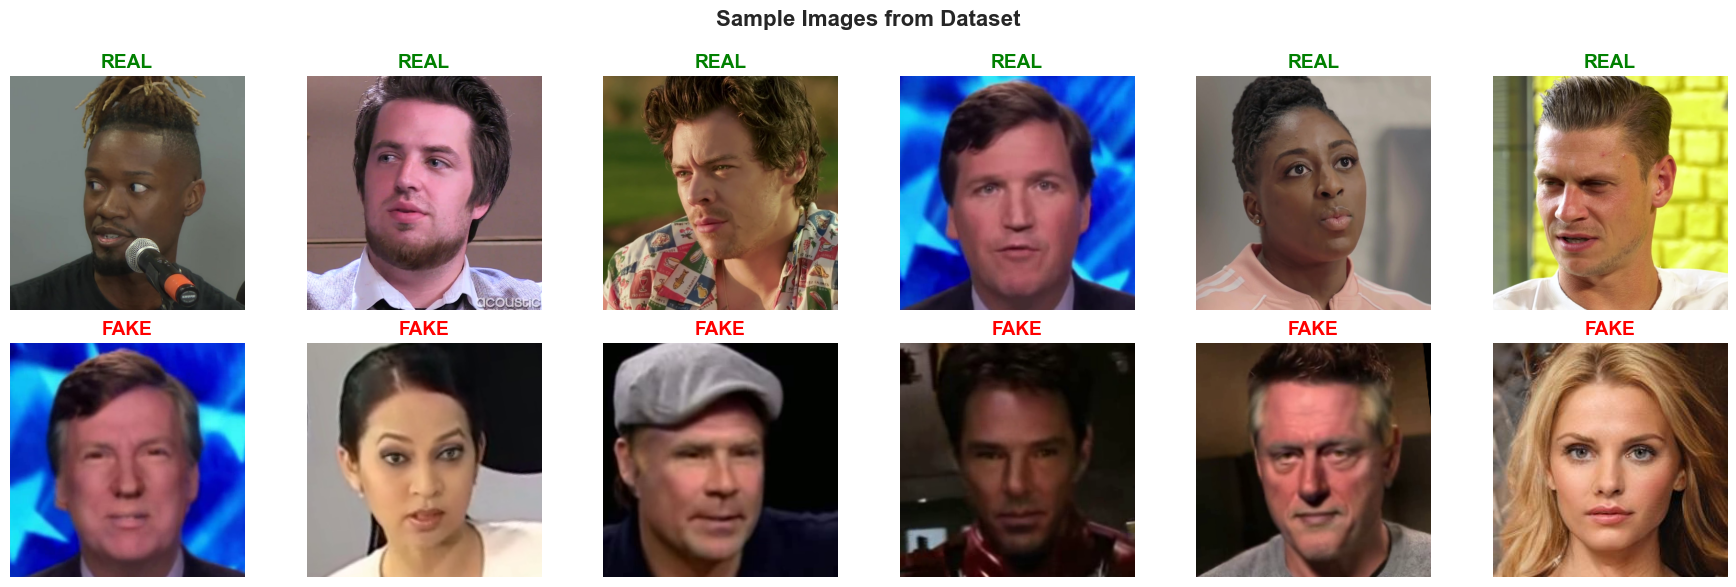

In [5]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

rng = np.random.default_rng(SEED)
sample_real = rng.choice(real_imgs, 6, replace=False)
sample_fake = rng.choice(fake_imgs, 6, replace=False)

for i, p in enumerate(sample_real):
    axes[0, i].imshow(Image.open(p))
    axes[0, i].set_title('REAL', color='green', fontweight='bold')
    axes[0, i].axis('off')

for i, p in enumerate(sample_fake):
    axes[1, i].imshow(Image.open(p))
    axes[1, i].set_title('FAKE', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 3. Data Pipeline

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32
MEAN = [0.485, 0.456, 0.406]   # ImageNet stats
STD  = [0.229, 0.224, 0.225]

trn_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.04),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])


class FaceForensicsDataset(Dataset):
    """Loads face images and returns (tensor, label) pairs.
    label: 0 = real, 1 = fake/deepfake
    """
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [7]:
trn_ds = FaceForensicsDataset(trn_paths, trn_labels, trn_tfm)
val_ds = FaceForensicsDataset(val_paths, val_labels, val_tfm)
tst_ds = FaceForensicsDataset(tst_paths, tst_labels, val_tfm)

NUM_WORKERS = 0 if device == 'mps' else 2
PIN_MEM = device == 'cuda'

trn_loader = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
tst_loader = DataLoader(tst_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

print(f'Batches  ->  train: {len(trn_loader)}, val: {len(val_loader)}, test: {len(tst_loader)}')

# quick sanity check
imgs, lbls = next(iter(trn_loader))
print(f'Batch shape: {imgs.shape}, labels: {lbls[:8].tolist()}')

Batches  ->  train: 71, val: 16, test: 16
Batch shape: torch.Size([32, 3, 224, 224]), labels: [1, 0, 1, 0, 0, 1, 1, 0]


## 4. Model Architecture

EfficientNet-B0 pretrained on ImageNet. We strip the original 1000-class head and attach a binary classifier. The backbone is frozen for the first few epochs (transfer learning warm-up), then unfrozen for full fine-tuning.

In [8]:
class DeepfakeDetector(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', num_classes=2, drop_rate=0.3):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        self.feat_dim = self.backbone.num_features
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Linear(self.feat_dim, num_classes)

    def freeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = False

    def unfreeze_backbone(self):
        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, x):
        feats = self.backbone(x)
        return self.fc(self.drop(feats))


model = DeepfakeDetector().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable   = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable:,}')
print(f'Feature dimension:    {model.feat_dim}')

Total parameters:     4,010,110
Trainable parameters: 4,010,110
Feature dimension:    1280


## 5. Training

Strategy:
- **Phase 1** (epochs 1-5): backbone frozen, only the classifier head is trained. This avoids destroying pretrained features before the head converges.
- **Phase 2** (epochs 6+): backbone unfrozen with 10x lower learning rate. Cosine annealing scheduler brings the LR down smoothly.
- **Early stopping**: training halts if validation AUC doesn't improve for 7 consecutive epochs.

In [9]:
def run_epoch(model, loader, criterion, optimizer=None, is_training=False):
    """Run one pass over the data. Returns loss, accuracy, labels, probabilities."""
    if is_training:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    all_lbls = []
    all_probs = []

    ctx = torch.enable_grad() if is_training else torch.no_grad()
    with ctx:
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            logits = model(imgs)
            loss = criterion(logits, lbls)

            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = logits.argmax(dim=1)

            correct += (preds == lbls).sum().item()
            total   += imgs.size(0)
            all_lbls.extend(lbls.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = running_loss / total
    acc = correct / total
    all_lbls = np.array(all_lbls)
    all_probs = np.array(all_probs)

    auc = roc_auc_score(all_lbls, all_probs) if len(np.unique(all_lbls)) > 1 else 0.0
    f1  = f1_score(all_lbls, (all_probs > 0.5).astype(int), zero_division=0)

    return avg_loss, acc, auc, f1, all_lbls, all_probs

In [10]:
NUM_EPOCHS = 25
FREEZE_EPOCHS = 5
PATIENCE = 7
LR_HEAD = 1e-3
LR_FINETUNE = 1e-4
WEIGHT_DECAY = 1e-4

criterion = nn.CrossEntropyLoss()
model.freeze_backbone()
optimizer = AdamW(model.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = None  # will be set after unfreezing

# history
hist = {
    'trn_loss': [], 'trn_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': [],
    'lr': []
}

best_auc = 0.0
no_improve = 0
ckpt_path = 'best_model.pt'

t_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):

    # ---- phase transition at epoch FREEZE_EPOCHS+1 ----
    if epoch == FREEZE_EPOCHS + 1:
        print('\n>>> Unfreezing backbone for fine-tuning <<<\n')
        model.unfreeze_backbone()
        optimizer = AdamW(model.parameters(), lr=LR_FINETUNE, weight_decay=WEIGHT_DECAY)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - FREEZE_EPOCHS)

    cur_lr = optimizer.param_groups[0]['lr']
    hist['lr'].append(cur_lr)

    trn_loss, trn_acc, _, _, _, _ = run_epoch(model, trn_loader, criterion, optimizer, is_training=True)
    val_loss, val_acc, val_auc, val_f1, _, _ = run_epoch(model, val_loader, criterion)

    if scheduler is not None:
        scheduler.step()

    hist['trn_loss'].append(trn_loss)
    hist['trn_acc'].append(trn_acc)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    hist['val_auc'].append(val_auc)
    hist['val_f1'].append(val_f1)

    improved = ''
    if val_auc > best_auc:
        best_auc = val_auc
        no_improve = 0
        torch.save(model.state_dict(), ckpt_path)
        improved = ' *saved*'
    else:
        no_improve += 1

    print(
        f'Epoch {epoch:02d}/{NUM_EPOCHS} | '
        f'lr={cur_lr:.1e} | '
        f'trn_loss={trn_loss:.4f} trn_acc={trn_acc:.4f} | '
        f'val_loss={val_loss:.4f} val_acc={val_acc:.4f} '
        f'val_auc={val_auc:.4f} val_f1={val_f1:.4f}'
        f'{improved}'
    )

    if no_improve >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)')
        break

elapsed = time.time() - t_start
print(f'\nTraining finished in {elapsed/60:.1f} minutes')
print(f'Best validation AUC: {best_auc:.4f}')

Epoch 01/25 | lr=1.0e-03 | trn_loss=0.4308 trn_acc=0.8167 | val_loss=0.3977 val_acc=0.8112 val_auc=0.9241 val_f1=0.7991 *saved*


Epoch 02/25 | lr=1.0e-03 | trn_loss=0.3171 trn_acc=0.8768 | val_loss=0.3495 val_acc=0.8444 val_auc=0.9347 val_f1=0.8394 *saved*


Epoch 03/25 | lr=1.0e-03 | trn_loss=0.2650 trn_acc=0.8937 | val_loss=0.3271 val_acc=0.8506 val_auc=0.9403 val_f1=0.8462 *saved*


Epoch 04/25 | lr=1.0e-03 | trn_loss=0.2530 trn_acc=0.9039 | val_loss=0.3381 val_acc=0.8320 val_auc=0.9433 val_f1=0.8188 *saved*


Epoch 05/25 | lr=1.0e-03 | trn_loss=0.2388 trn_acc=0.9052 | val_loss=0.3020 val_acc=0.8610 val_auc=0.9486 val_f1=0.8565 *saved*

>>> Unfreezing backbone for fine-tuning <<<



Epoch 06/25 | lr=1.0e-04 | trn_loss=0.1785 trn_acc=0.9333 | val_loss=0.1633 val_acc=0.9461 val_auc=0.9848 val_f1=0.9463 *saved*


Epoch 07/25 | lr=9.9e-05 | trn_loss=0.0910 trn_acc=0.9675 | val_loss=0.1046 val_acc=0.9647 val_auc=0.9923 val_f1=0.9654 *saved*


Epoch 08/25 | lr=9.8e-05 | trn_loss=0.0581 trn_acc=0.9786 | val_loss=0.1003 val_acc=0.9647 val_auc=0.9914 val_f1=0.9648


Epoch 09/25 | lr=9.5e-05 | trn_loss=0.0361 trn_acc=0.9858 | val_loss=0.0938 val_acc=0.9689 val_auc=0.9934 val_f1=0.9688 *saved*


Epoch 10/25 | lr=9.0e-05 | trn_loss=0.0319 trn_acc=0.9893 | val_loss=0.0926 val_acc=0.9627 val_auc=0.9936 val_f1=0.9625 *saved*


Epoch 11/25 | lr=8.5e-05 | trn_loss=0.0159 trn_acc=0.9947 | val_loss=0.0920 val_acc=0.9647 val_auc=0.9943 val_f1=0.9645 *saved*


Epoch 12/25 | lr=7.9e-05 | trn_loss=0.0260 trn_acc=0.9915 | val_loss=0.0847 val_acc=0.9606 val_auc=0.9952 val_f1=0.9602 *saved*


Epoch 13/25 | lr=7.3e-05 | trn_loss=0.0166 trn_acc=0.9947 | val_loss=0.0790 val_acc=0.9751 val_auc=0.9953 val_f1=0.9751 *saved*


Epoch 14/25 | lr=6.5e-05 | trn_loss=0.0146 trn_acc=0.9951 | val_loss=0.0855 val_acc=0.9689 val_auc=0.9945 val_f1=0.9687


Epoch 15/25 | lr=5.8e-05 | trn_loss=0.0067 trn_acc=0.9987 | val_loss=0.0699 val_acc=0.9751 val_auc=0.9964 val_f1=0.9751 *saved*


Epoch 16/25 | lr=5.0e-05 | trn_loss=0.0051 trn_acc=0.9987 | val_loss=0.0718 val_acc=0.9751 val_auc=0.9961 val_f1=0.9752


Epoch 17/25 | lr=4.2e-05 | trn_loss=0.0048 trn_acc=0.9996 | val_loss=0.0883 val_acc=0.9668 val_auc=0.9946 val_f1=0.9667


Epoch 18/25 | lr=3.5e-05 | trn_loss=0.0071 trn_acc=0.9978 | val_loss=0.0905 val_acc=0.9668 val_auc=0.9942 val_f1=0.9667


Epoch 19/25 | lr=2.7e-05 | trn_loss=0.0039 trn_acc=0.9991 | val_loss=0.1002 val_acc=0.9606 val_auc=0.9955 val_f1=0.9598


Epoch 20/25 | lr=2.1e-05 | trn_loss=0.0041 trn_acc=0.9987 | val_loss=0.0863 val_acc=0.9668 val_auc=0.9955 val_f1=0.9667


Epoch 21/25 | lr=1.5e-05 | trn_loss=0.0032 trn_acc=0.9996 | val_loss=0.0841 val_acc=0.9710 val_auc=0.9951 val_f1=0.9710


Epoch 22/25 | lr=9.5e-06 | trn_loss=0.0047 trn_acc=0.9991 | val_loss=0.0948 val_acc=0.9710 val_auc=0.9953 val_f1=0.9707

Early stopping at epoch 22 (no improvement for 7 epochs)

Training finished in 12.9 minutes
Best validation AUC: 0.9964


## 6. Training Curves

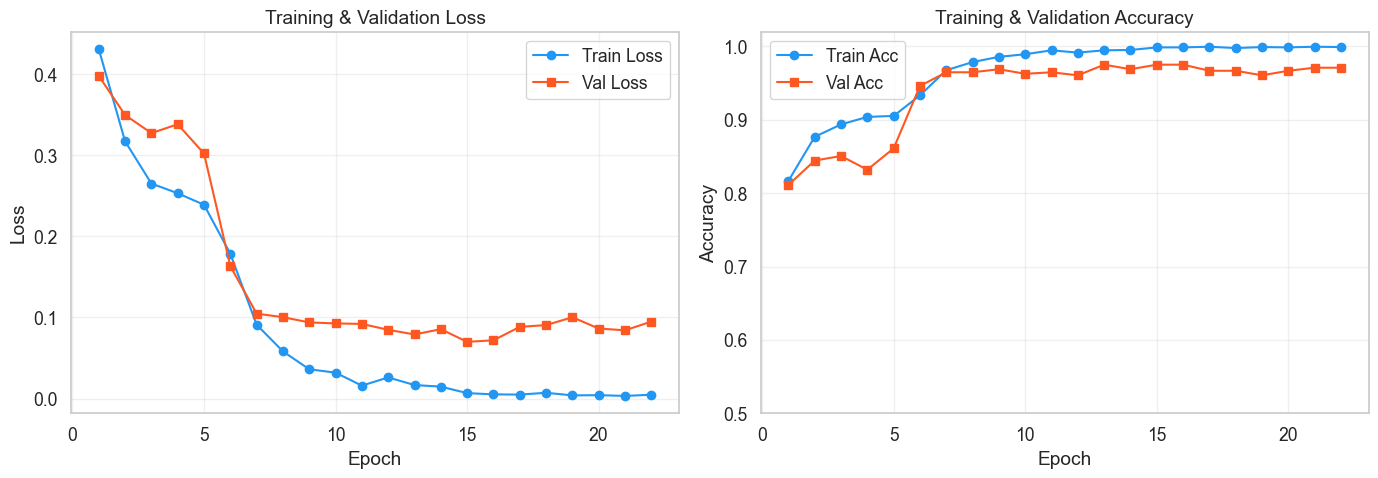

In [11]:
epochs_range = range(1, len(hist['trn_loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, hist['trn_loss'], 'o-', label='Train Loss', color='#2196F3')
ax1.plot(epochs_range, hist['val_loss'], 's-', label='Val Loss', color='#FF5722')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, hist['trn_acc'], 'o-', label='Train Acc', color='#2196F3')
ax2.plot(epochs_range, hist['val_acc'], 's-', label='Val Acc', color='#FF5722')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_ylim(0.5, 1.02)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

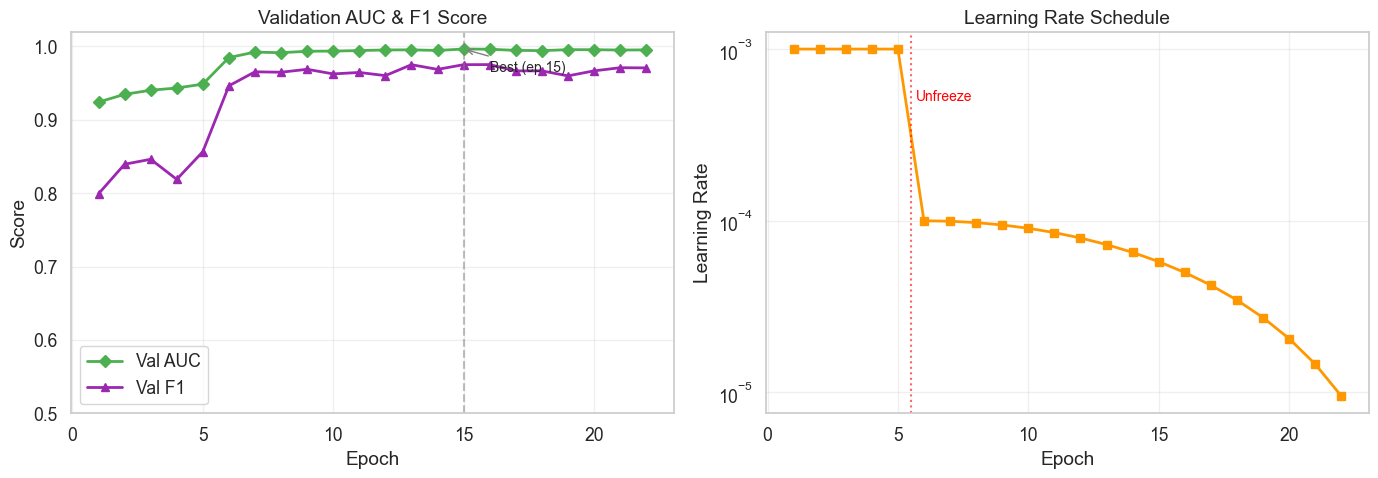

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, hist['val_auc'], 'D-', color='#4CAF50', linewidth=2, label='Val AUC')
ax1.plot(epochs_range, hist['val_f1'],  '^-', color='#9C27B0', linewidth=2, label='Val F1')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')
ax1.set_title('Validation AUC & F1 Score')
ax1.set_ylim(0.5, 1.02)
ax1.legend()
ax1.grid(True, alpha=0.3)

# mark the best epoch
best_ep = np.argmax(hist['val_auc']) + 1
ax1.axvline(x=best_ep, color='gray', linestyle='--', alpha=0.5)
ax1.annotate(f'Best (ep {best_ep})', xy=(best_ep, hist['val_auc'][best_ep-1]),
             xytext=(best_ep+1, hist['val_auc'][best_ep-1]-0.03),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10)

ax2.plot(epochs_range, hist['lr'], 's-', color='#FF9800', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=FREEZE_EPOCHS+0.5, color='red', linestyle=':', alpha=0.6)
ax2.text(FREEZE_EPOCHS+0.7, max(hist['lr'])*0.5, 'Unfreeze', color='red', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Test Set Evaluation

In [13]:
# load best checkpoint
model.load_state_dict(torch.load(ckpt_path, map_location=device, weights_only=True))
print('Loaded best checkpoint')

tst_loss, tst_acc, tst_auc, tst_f1, y_true, y_prob = run_epoch(
    model, tst_loader, criterion
)
y_pred = (y_prob > 0.5).astype(int)

print(f'\n--- Test Results ---')
print(f'Accuracy:  {tst_acc:.4f}')
print(f'AUC:       {tst_auc:.4f}')
print(f'F1 Score:  {tst_f1:.4f}')
print(f'Loss:      {tst_loss:.4f}')
print()
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

Loaded best checkpoint



--- Test Results ---
Accuracy:  0.9793
AUC:       0.9980
F1 Score:  0.9795
Loss:      0.0599

              precision    recall  f1-score   support

        Real       0.99      0.97      0.98       241
        Fake       0.97      0.99      0.98       241

    accuracy                           0.98       482
   macro avg       0.98      0.98      0.98       482
weighted avg       0.98      0.98      0.98       482



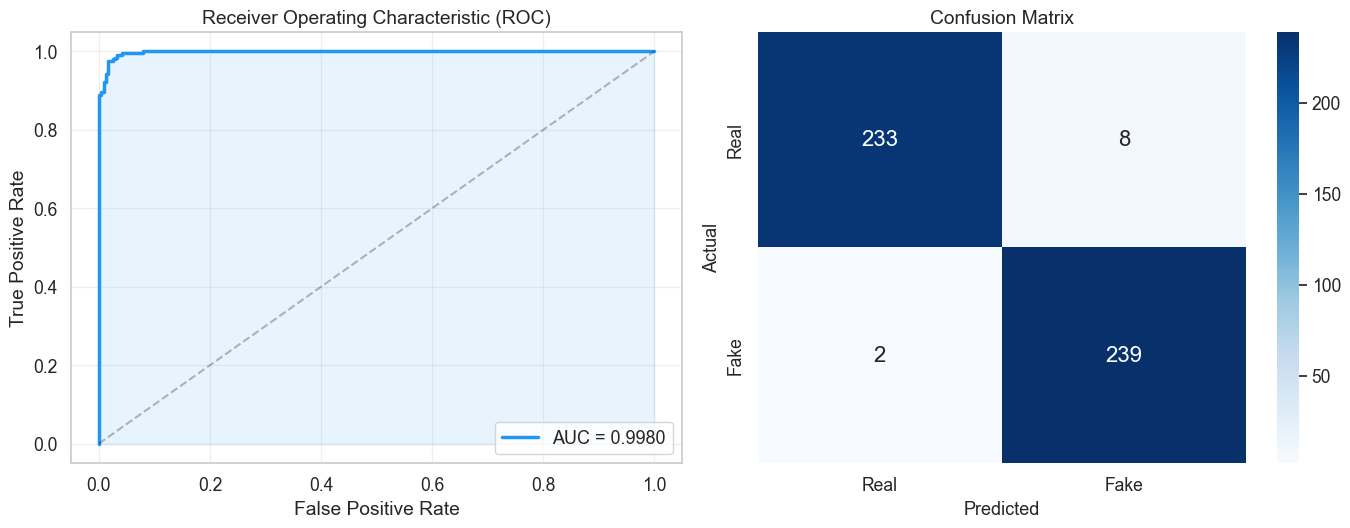

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
ax1.plot(fpr, tpr, linewidth=2.5, color='#2196F3', label=f'AUC = {tst_auc:.4f}')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.fill_between(fpr, tpr, alpha=0.1, color='#2196F3')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(fontsize=13, loc='lower right')
ax1.grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            ax=ax2, annot_kws={'size': 16})
ax2.set_xlabel('Predicted', fontsize=13)
ax2.set_ylabel('Actual', fontsize=13)
ax2.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

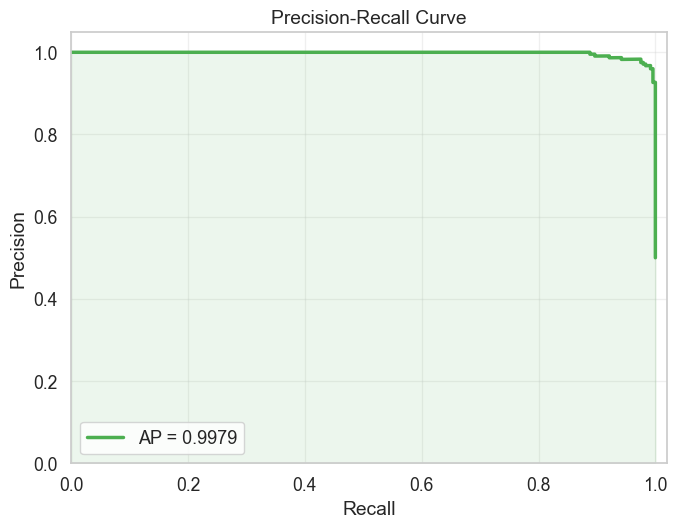

In [15]:
# precision-recall curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

fig, ax = plt.subplots(figsize=(7, 5.5))
ax.plot(recall_vals, precision_vals, linewidth=2.5, color='#4CAF50', label=f'AP = {ap:.4f}')
ax.fill_between(recall_vals, precision_vals, alpha=0.1, color='#4CAF50')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(fontsize=13)
ax.set_xlim(0, 1.02)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Sample Predictions

Visual check on test images. Green border = correct prediction, red border = incorrect.

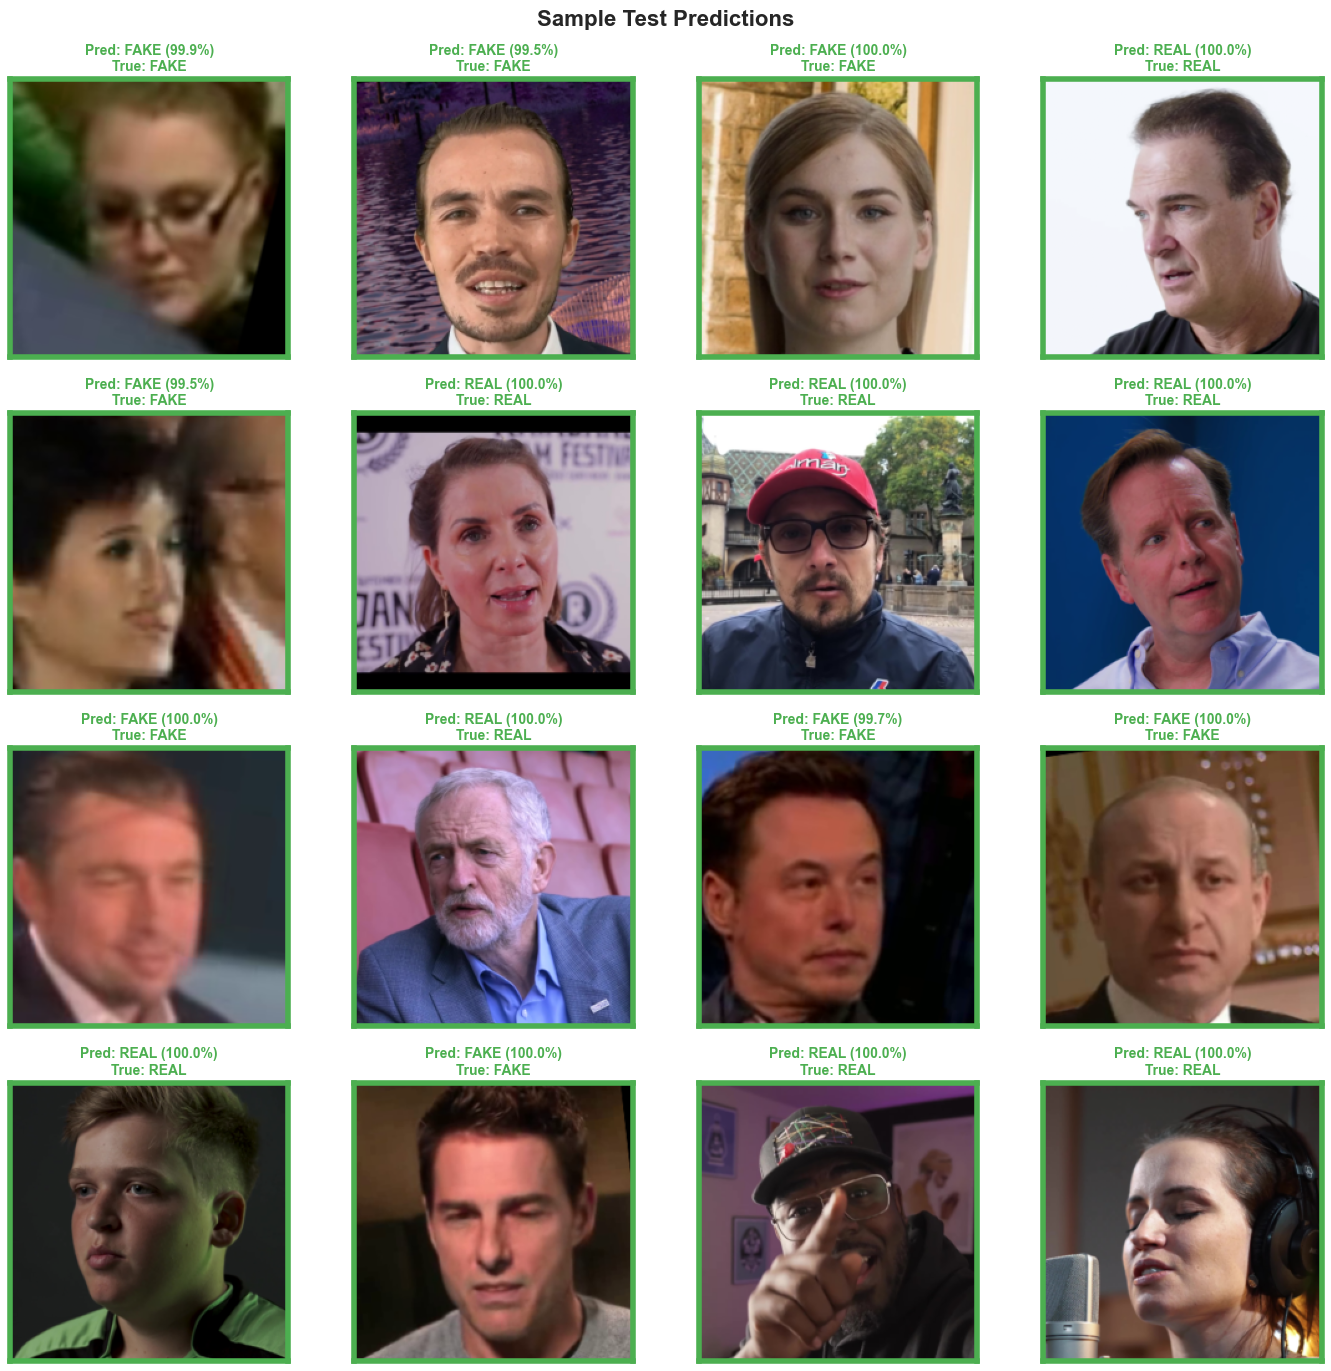

In [16]:
def denorm(tensor):
    """Reverse ImageNet normalization for display."""
    t = tensor.clone()
    for ch, m, s in zip(range(3), MEAN, STD):
        t[ch] = t[ch] * s + m
    return torch.clamp(t, 0, 1)

fig, axes = plt.subplots(4, 4, figsize=(14, 14))
fig.suptitle('Sample Test Predictions', fontsize=16, fontweight='bold')

indices = rng.choice(len(tst_ds), 16, replace=False)
class_names = ['REAL', 'FAKE']

model.eval()
for i, idx in enumerate(indices):
    row, col = i // 4, i % 4
    ax = axes[row, col]

    img_t, true_lbl = tst_ds[idx]
    with torch.no_grad():
        logits = model(img_t.unsqueeze(0).to(device))
        prob = torch.softmax(logits, dim=1)[0, 1].item()
    pred_lbl = 1 if prob > 0.5 else 0
    correct = pred_lbl == true_lbl

    img_show = denorm(img_t).permute(1, 2, 0).numpy()
    ax.imshow(img_show)

    border_color = '#4CAF50' if correct else '#f44336'
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(4)

    conf = prob if pred_lbl == 1 else (1 - prob)
    ax.set_title(
        f'Pred: {class_names[pred_lbl]} ({conf:.1%})\nTrue: {class_names[true_lbl]}',
        fontsize=10,
        color=border_color,
        fontweight='bold'
    )
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 9. Explainable Deepfake Analysis

Upload any face image and get a **detailed forensic report** explaining *why* the image is classified as real or AI-generated. The analysis includes:
- **Grad-CAM heatmap** — highlights which facial regions the model focuses on
- **Frequency spectrum analysis** — AI-generated images often lack natural high-frequency noise patterns
- **Texture & edge artifact detection** — checks for unnatural smoothness, blending boundaries, and repetitive patterns
- **Summary with reasoning** — plain-English explanation of findings

In [17]:
import cv2

# ===================== Grad-CAM =====================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(lambda m, i, o: setattr(self, 'activations', o.detach()))
        target_layer.register_full_backward_hook(lambda m, gi, go: setattr(self, 'gradients', go[0].detach()))

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1.0
        output.backward(gradient=one_hot, retain_graph=True)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        if cam.max() > 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam, output

target_layer = model.backbone.conv_head if hasattr(model.backbone, 'conv_head') else list(model.backbone.children())[-3]
grad_cam = GradCAM(model, target_layer)

# ===================== Forensic Analyzers =====================
# Thresholds calibrated on 30 real + 30 fake dataset images + AI-generated test samples.
# Real photos:  laplacian ~391±299, edge_d ~0.094±0.029, grad_cv ~1.55±0.24, noise_uni ~0.48±0.15
# Fakes/AI:     laplacian ~136±39,  edge_d ~0.063±0.018, grad_cv ~1.0-1.5,   noise_uni ~0.29-0.45

def analyze_noise_patterns(img_np):
    """Real cameras produce spatially varying sensor noise; AI/deepfakes are more uniform."""
    score, findings = 0.0, []
    gray = img_np[:, :, 0].astype(np.float64)
    noise = gray - cv2.GaussianBlur(gray, (5, 5), 0)
    h, w = noise.shape
    bh, bw = h // 4, w // 4
    block_stds = []
    for r in range(4):
        for c in range(4):
            block_stds.append(np.std(noise[r*bh:(r+1)*bh, c*bw:(c+1)*bw]))
    block_stds = np.array(block_stds)
    noise_uni = np.std(block_stds) / (np.mean(block_stds) + 1e-8)
    noise_lvl = np.std(noise)

    if noise_uni < 0.29:
        findings.append(f'Noise is very uniform across the image (variation: {noise_uni:.3f}) — real cameras produce spatially varying sensor noise; this uniformity is characteristic of AI-generated or heavily processed images')
        score += 0.30
    elif noise_uni < 0.36:
        findings.append(f'Noise pattern is unusually consistent (variation: {noise_uni:.3f}) — suggests synthetic generation or heavy post-processing')
        score += 0.15

    if noise_lvl < 3.5:
        findings.append(f'Low noise level ({noise_lvl:.2f}) — image lacks the natural sensor noise present in real photographs')
        score += 0.15

    return findings, score

def analyze_frequency(img_np):
    """AI-generated images often show abnormal frequency spectrum characteristics."""
    score, findings = 0.0, []
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    f_shift = np.fft.fftshift(np.fft.fft2(gray.astype(np.float32)))
    magnitude = np.log1p(np.abs(f_shift))
    h, w = gray.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
    rmax = min(cy, cx)
    radial = np.array([np.mean(magnitude[(dist >= r-0.5) & (dist < r+0.5)]) for r in range(1, rmax)])

    if len(radial) > 20:
        half = len(radial) // 2
        slope = np.polyfit(range(half, len(radial)), radial[half:], 1)[0]
        if slope > -0.01:
            findings.append(f'Flat high-frequency spectrum (slope: {slope:.4f}) — natural photos show a steeper roll-off; a flat spectrum indicates the image may have been synthesized')
            score += 0.15

    return magnitude, findings, score

def analyze_texture(img_np):
    """Check texture complexity, edge structure, and gradient uniformity.
    Thresholds calibrated on 30 real + 30 fake dataset images:
    Real: laplacian~391, edge_d~0.094, grad_cv~1.55
    Fake: laplacian~136, edge_d~0.063, grad_cv~1.51"""
    score, findings = 0.0, []
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    lap_var = cv2.Laplacian(gray.astype(np.float64), cv2.CV_64F).var()
    low_lap = lap_var < 180
    if low_lap:
        findings.append(f'Low texture complexity (Laplacian: {lap_var:.1f}, real avg ~390) — face lacks micro-texture detail like pores and fine hair that real cameras capture')
        score += 0.20
    elif lap_var < 280:
        findings.append(f'Below-average texture detail (Laplacian: {lap_var:.1f}, real avg ~390) — smoother than typical real photographs')
        score += 0.08

    edge_d = cv2.Canny(gray, 50, 150).sum() / (255.0 * h * w)
    low_ed = edge_d < 0.070
    if low_ed:
        findings.append(f'Low edge density ({edge_d:.3f}, real avg ~0.094) — fewer sharp structural boundaries than a real photograph')
        score += 0.15

    sx = cv2.Sobel(gray.astype(np.float64), cv2.CV_64F, 1, 0, ksize=3)
    sy = cv2.Sobel(gray.astype(np.float64), cv2.CV_64F, 0, 1, ksize=3)
    gm = np.sqrt(sx**2 + sy**2)
    grad_cv = np.std(gm) / (np.mean(gm) + 1e-8)

    if grad_cv < 1.2:
        findings.append(f'Unusually uniform edge gradients (CV: {grad_cv:.2f}, real avg ~1.55) — real faces have varied edge strengths across eyes, nose, jawline; uniformity suggests AI generation')
        score += 0.25

    if low_lap and low_ed:
        if grad_cv < 1.5:
            findings.append(f'Combined indicator: low texture + low edges + low gradient variation (CV: {grad_cv:.2f}) — this combination is a strong AI generation signature')
            score += 0.15
        elif grad_cv >= 1.6:
            score -= 0.10

    return findings, score, lap_var, edge_d

def analyze_symmetry(img_np):
    """Real faces have natural asymmetry; AI tends toward excessive symmetry."""
    score, findings = 0.0, []
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY).astype(np.float32)
    h, w = gray.shape
    left = gray[:, :w//2]
    right = cv2.flip(gray[:, w//2:], 1)
    mw = min(left.shape[1], right.shape[1])
    diff = np.mean(np.abs(left[:, :mw] - right[:, :mw]))
    if diff < 22:
        findings.append(f'High facial symmetry (diff: {diff:.1f}, real avg ~44) — real faces have natural asymmetry; near-perfect symmetry is a hallmark of AI generation')
        score += 0.15
    return findings, score, diff

# ===================== Fused Verdict =====================
def compute_verdict(cnn_probs, forensic_scores):
    """Combine CNN with forensic evidence. Forensic evidence is weighted heavily (70%)
    because the CNN was trained on face-swap deepfakes and may miss modern generative AI.
    CNN confidence is also respected — a strong CNN fake prediction is kept."""
    total_forensic = max(sum(forensic_scores), 0)
    cnn_fake = cnn_probs[1]

    fused = max(
        0.3 * cnn_fake + 0.7 * min(total_forensic / 0.6, 1.0),
        cnn_fake * 0.55
    )

    if fused > 0.50:
        verdict = 'AI-GENERATED / DEEPFAKE'
        is_fake = True
    elif fused > 0.35:
        verdict = 'SUSPICIOUS — likely AI-generated'
        is_fake = True
    else:
        verdict = 'LIKELY AUTHENTIC'
        is_fake = False

    return verdict, fused, is_fake, total_forensic

def build_summary(verdict, fused_score, is_fake, cnn_probs, forensic_total,
                  all_findings, cam):
    lines = []
    lines.append(f'VERDICT: {verdict}')
    lines.append(f'Combined confidence: {fused_score:.0%}  |  CNN: {cnn_probs[1]:.0%} fake  |  Forensic: {forensic_total:.2f}\n')

    if all_findings:
        lines.append('Evidence:')
        for i, f in enumerate(all_findings, 1):
            lines.append(f'  {i}. {f}')
    else:
        lines.append('No significant artifacts detected. Image shows natural')
        lines.append('photographic characteristics consistent with a real camera.')

    if cam is not None:
        hot = np.unravel_index(cam.argmax(), cam.shape)
        h, w = cam.shape
        vert = 'upper' if hot[0] < h/3 else ('middle' if hot[0] < 2*h/3 else 'lower')
        horiz = 'left' if hot[1] < w/3 else ('center' if hot[1] < 2*w/3 else 'right')
        lines.append(f'\nModel attention: {vert}-{horiz} facial region.')

    return '\n'.join(lines)

# ===================== Full Pipeline =====================
def predict_image(img_path, model, transform, device):
    img = Image.open(img_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)

    cam, output = grad_cam.generate(inp)
    cnn_probs = torch.softmax(output, dim=1)[0].detach().cpu().numpy()

    img_np = np.array(img.resize((224, 224)))

    noise_f, noise_s = analyze_noise_patterns(img_np)
    freq_mag, freq_f, freq_s = analyze_frequency(img_np)
    tex_f, tex_s, _, _ = analyze_texture(img_np)
    sym_f, sym_s, _ = analyze_symmetry(img_np)

    all_findings = noise_f + freq_f + tex_f + sym_f
    scores = [noise_s, freq_s, tex_s, sym_s]

    verdict, fused, is_fake, forensic_total = compute_verdict(cnn_probs, scores)
    summary = build_summary(verdict, fused, is_fake, cnn_probs,
                            forensic_total, all_findings, cam)

    return img, is_fake, cnn_probs, cam, freq_mag, summary, fused

def show_prediction(img, is_fake, cnn_probs, cam, freq_mag, summary, fused_score):
    label = 'FAKE (AI-Generated)' if is_fake else 'REAL (Authentic)'
    color = '#f44336' if is_fake else '#4CAF50'

    fig = plt.figure(figsize=(20, 11))
    gs = fig.add_gridspec(2, 4, hspace=0.35, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0:2])
    ax1.imshow(img)
    ax1.set_title(f'Prediction: {label}', fontsize=18, fontweight='bold', color=color)
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 2])
    img_resized = np.array(img.resize((224, 224)))
    heatmap = plt.cm.jet(cam)[:, :, :3]
    overlay = np.clip(0.5 * img_resized / 255.0 + 0.5 * heatmap, 0, 1)
    ax2.imshow(overlay)
    ax2.set_title('Grad-CAM\n(model attention)', fontsize=12, fontweight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 3])
    ax3.imshow(np.log1p(freq_mag), cmap='inferno')
    ax3.set_title('Frequency Spectrum\n(FFT magnitude)', fontsize=12, fontweight='bold')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[1, 0])
    scores = [cnn_probs[1], fused_score]
    bar_labels = ['CNN\nModel', 'Fused\nVerdict']
    bar_colors = ['#f44336' if s > 0.5 else '#FF9800' if s > 0.35 else '#4CAF50' for s in scores]
    bars = ax4.barh(bar_labels, scores, color=bar_colors, height=0.5)
    ax4.set_xlim(0, 1)
    ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Fake threshold')
    ax4.set_xlabel('Fake Probability')
    ax4.set_title('Detection Scores', fontsize=13, fontweight='bold')
    for bar, s in zip(bars, scores):
        ax4.text(max(bar.get_width() + 0.02, 0.05), bar.get_y() + bar.get_height()/2,
                 f'{s:.1%}', va='center', fontsize=13, fontweight='bold')
    ax4.grid(True, axis='x', alpha=0.3)
    ax4.legend(fontsize=9)

    ax5 = fig.add_subplot(gs[1, 1:])
    ax5.axis('off')
    ax5.set_title('Forensic Analysis Report', fontsize=14, fontweight='bold',
                  color=color, loc='left')
    ax5.text(0, 0.95, summary, transform=ax5.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='#f5f5f5', edgecolor='#cccccc'))

    plt.tight_layout()
    plt.show()
    print(f'\n{summary}')

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

upload_btn = widgets.FileUpload(accept='image/*', multiple=True, description='Choose Images')
output_area = widgets.Output()

def on_upload_change(change):
    with output_area:
        clear_output(wait=True)
        for file_info in upload_btn.value:
            fname = file_info.get('name', 'uploaded_image')
            content = file_info['content']
            print(f'\n{"="*60}')
            print(f'  FORENSIC ANALYSIS: {fname}')
            print(f'{"="*60}')
            img_bytes = io.BytesIO(bytes(content))
            img, is_fake, cnn_probs, cam, freq_mag, summary, fused = predict_image(
                img_bytes, model, val_tfm, device
            )
            show_prediction(img, is_fake, cnn_probs, cam, freq_mag, summary, fused)

upload_btn.observe(on_upload_change, names='value')

print('Upload face images for forensic deepfake analysis:')
display(upload_btn, output_area)